In [1]:
import sys, os
import numpy as np
import h5py
import random
import neptune
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp

from tqdm import tqdm
from tensorflow import keras
from tensorflow_probability import layers as tfpl
from tensorflow_probability import distributions as tfd
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Cropping2D, Concatenate, Input, MaxPooling2D, Conv2D, Conv2DTranspose, Flatten, Dropout, Dense, BatchNormalization, Activation, Reshape, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow_probability.python.distributions import kl_divergence
from neptune.integrations.tensorflow_keras import NeptuneCallback
from DataMakerCVAE import *

2023-11-11 00:08:50.045335: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-11 00:08:50.727735: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
LATENT_DIM = 128
IMAGE_SHAPE = (5, 127, 127)
BATCH_SIZE = 512
EPOCHS = 250
CHECKPOINTS_TO_SAVE = 4
KL_WEIGHT = 1e-3

In [3]:
gpus = tf.config.list_physical_devices('GPU');
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit = 20000)]);
        logical_gpus = tf.config.experimental.list_logical_devices('GPU');
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


2023-11-11 00:08:51.894092: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-11 00:08:51.975544: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-11 00:08:51.975792: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [4]:
args_gen = {'X_key' : 'image',
    'y_key' : 'specz_redshift',
    'scaler' : False,
    'labels_encoding' : False,
    'batch_size': BATCH_SIZE,
    'mode' : 'train',
    'shuffle' : False}

train_gen = HDF5ImageGenerator(src = '/data/HSC/HSC_v6/step2A/127x127/5x127x127_training.hdf5', **args_gen)
test_gen = HDF5ImageGenerator(src = '/data/HSC/HSC_v6/step2A/127x127/5x127x127_testing.hdf5', **args_gen)
val_gen = HDF5ImageGenerator(src = '/data/HSC/HSC_v6/step2A/127x127/5x127x127_validation.hdf5', **args_gen)

In [5]:
# Prior
prior = tfd.Independent(tfd.Normal(loc = tf.zeros(LATENT_DIM), scale = 1.0), reinterpreted_batch_ndims = 1)

# Encoder
images = Input(shape = IMAGE_SHAPE)
redshifts = Input(shape = (1,))
conv1 = Conv2D(32, 3, strides = 2, activation = "relu", padding = 'same', data_format = 'channels_first')(images)
conv2 = Conv2D(64, 3, strides = 2, activation = "relu", padding = 'same', data_format = 'channels_first')(conv1)
conv3 = Conv2D(128, 2, strides = 1, activation = "relu", padding = 'same', data_format = 'channels_first')(conv2)
flatten1 = Flatten()(conv1)
flatten2 = Flatten()(conv2)
flatten3 = Flatten()(conv3)
x = tf.keras.layers.Concatenate()([flatten1, flatten2, flatten3, redshifts])
x = Dense(256, activation = "relu")(x)
x = Dense(256, activation = "relu")(x)
x = Dense(tfpl.MultivariateNormalTriL.params_size(LATENT_DIM), activation = None)(x)
z = tfpl.MultivariateNormalTriL(LATENT_DIM, activity_regularizer = tfpl.KLDivergenceRegularizer(prior, weight=KL_WEIGHT))(x)

encoder = Model([images, redshifts], z)

2023-11-11 00:08:52.299142: I tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:736] failed to allocate 19.53GiB (20971520000 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory


In [6]:
encoder.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 5, 127, 127  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 32, 64, 64)   1472        ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 64, 32, 32)   18496       ['conv2d[0][0]']                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 128, 32, 32)  32896       ['conv2d_1[0][0]']           

In [7]:
zc = Input(shape = (LATENT_DIM + 1,))
x = Dense(256, activation = "relu")(zc)
x = Dense(256, activation = "relu")(x)
x = Dense(128 * 32 * 32 + 64 * 32 * 32 + 32 * 64 * 64, activation = "relu")(x)
dense1, dense2, dense3 = tf.split(x, [128 * 32 * 32, 64 * 32 * 32, 32 * 64 * 64], axis = 1)
reshape1 = Reshape((128, 32, 32))(dense1)
reshape2 = Reshape((64, 32, 32))(dense2)
reshape3 = Reshape((32, 64, 64))(dense3)
deconv1 = Conv2DTranspose(64, 2, strides = 1, activation = "relu", padding = 'same', data_format = 'channels_first')(reshape1)
deconv2 = Conv2DTranspose(32, 3, strides = 2, activation = "relu", padding = 'same', data_format = 'channels_first')(reshape2 + deconv1)
deconv3 = Conv2DTranspose(5, 3, strides = 2, activation = "relu", padding = 'same', data_format = 'channels_first')(reshape3 + deconv2)
cropping = Cropping2D(cropping = ((0, 1), (0, 1)), data_format = 'channels_first')(deconv3)

outputs = Reshape(IMAGE_SHAPE)(cropping)

decoder = Model(zc, outputs)

In [8]:
z = encoder([images, redshifts])
zc = tf.keras.layers.Concatenate()([z, redshifts])  # Assuming you want to concat the output of encoder and redshifts
decoder_output = decoder(zc)

model = Model(inputs = [images, redshifts], outputs = decoder_output)

In [9]:
encoder.summary()
decoder.summary()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 5, 127, 127  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 32, 64, 64)   1472        ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 64, 32, 32)   18496       ['conv2d[0][0]']                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 128, 32, 32)  32896       ['conv2d_1[0][0]']           

In [10]:
optimizer = Adam(learning_rate = 0.001)
model.compile(optimizer = optimizer, loss = 'mse')

In [ ]:
run = neptune.init_run(
    name = "CVAE",
    project = "astro-data-lab/VAE",
    api_token = "eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIxOGFlZGMxOC04MWU5LTQ2NDctYjlhZS05NGE2NGQ0NmIzMmEifQ==",
)  # your credentials

model_name = 'cvae_127_150'

weights_path = os.path.join('/data3/Billy/models/', model_name) + '/weights'

neptune_callback = NeptuneCallback(run = run)

LR_callback = ReduceLROnPlateau()

In [66]:
history = model.fit(train_gen, epochs = 20, callbacks = [neptune_callback, LR_callback], validation_data = val_gen, verbose = 1)

Epoch 1/20


2023-11-12 11:40:37.442385: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


400/400 [==============================] - 1443s 4s/step - loss: 0.9528 - val_loss: 1.2686 - lr: 1.0000e-04
Epoch 2/20
400/400 [==============================] - 1450s 4s/step - loss: 0.9500 - val_loss: 1.2491 - lr: 1.0000e-04
Epoch 3/20
400/400 [==============================] - 1500s 4s/step - loss: 0.9474 - val_loss: 1.2640 - lr: 1.0000e-04
Epoch 4/20
400/400 [==============================] - 1487s 4s/step - loss: 0.9442 - val_loss: 1.2627 - lr: 1.0000e-04
Epoch 5/20
400/400 [==============================] - 1487s 4s/step - loss: 0.9424 - val_loss: 1.2540 - lr: 1.0000e-04
Epoch 6/20
400/400 [==============================] - 1492s 4s/step - loss: 0.9463 - val_loss: 1.2526 - lr: 1.0000e-04
Epoch 7/20
400/400 [==============================] - ETA: 0s - loss: 0.9370

KeyboardInterrupt: 

In [65]:
model.save_weights(weights_path)

In [63]:
model.load_weights(weights_path)

z = 0.0843899995


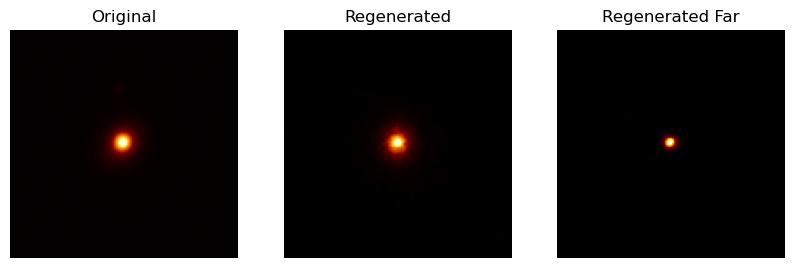

In [73]:
lib = 3
index = 466
z = test_gen[lib][0][1][index]
z_shifted = 2
band = 0
print(f'z = {z}')
str = np.asarray(encoder([np.array([test_gen[lib][0][0][index]]), np.array([test_gen[lib][0][1][index]])])[0])
str = np.concatenate((str, np.array([z])))
str = str.reshape(1, LATENT_DIM + 1)
str_shifted = np.asarray(encoder([np.array([test_gen[lib][0][0][index]]), np.array([test_gen[lib][0][1][index]])])[0])
str_shifted = np.concatenate((str_shifted, np.array([z_shifted])))
str_shifted = str_shifted.reshape(1, LATENT_DIM + 1)
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (10, 5))
axes[0].imshow(test_gen[lib][0][0][index][band], cmap = 'afmhot')
axes[1].imshow(decoder([str])[0][band], cmap = 'afmhot')
axes[2].imshow(decoder([str_shifted])[0][band], cmap = 'afmhot')
axes[0].axis('off')
axes[1].axis('off')
axes[2].axis('off')
axes[0].set_title("Original")
axes[1].set_title("Regenerated")
axes[2].set_title("Regenerated Far")
plt.show()

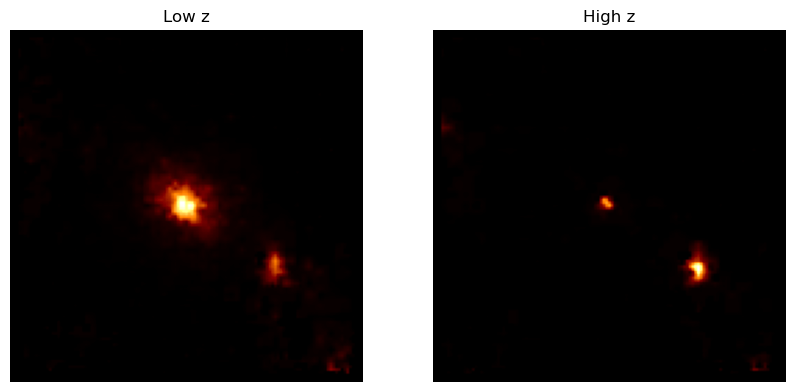

In [81]:
band = 0
str = prior.sample(1)[0]
strlo = np.concatenate((str, np.array([0.1])))
strlo = strlo.reshape(1, LATENT_DIM + 1)
strhi = np.concatenate((str, np.array([2])))
strhi = strhi.reshape(1, LATENT_DIM + 1)
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 5))
axes[0].imshow(decoder([strlo])[0][band], cmap = 'afmhot')
axes[1].imshow(decoder([strhi])[0][band], cmap = 'afmhot')
axes[0].axis('off')
axes[1].axis('off')
axes[0].set_title("Low z")
axes[1].set_title("High z")
plt.show()

for j in range(3, 80):
    for i in range(0, 512):
        if test_gen[j][0][1][i] <= 0.1:
            print(j)
            print(i)

In [83]:
hf = h5py.File('/data/HSC_generated/HSC_generated_v1/step1/127x127/5x127x127_visual_quality', 'a')
str = prior.sample(1)[0]
str = np.concatenate((str, np.array([0.1])))
str = str.reshape(1, LATENT_DIM + 1)
output_image = decoder([str])[0]
image_g = output_image[0]
image_r = output_image[1]
image_i = output_image[2]
image_z = output_image[3]
image_y = output_image[4]
five_band_image = []
five_band_image.append(image_g)
five_band_image.append(image_r)
five_band_image.append(image_i)
five_band_image.append(image_z)
five_band_image.append(image_y)
five_band_image_reshape = np.reshape(np.array(five_band_image), [1, 5, 127, 127])
hf.create_dataset('image', data = five_band_image_reshape, chunks = True, maxshape = (None, 5, 127, 127))
hf.create_dataset('specz_redshift', data = [0.1], chunks = True, maxshape = (None, ))
for i in tqdm(range(40913)):
    z = random.uniform(0, 2)
    str = prior.sample(1)[0]
    str = np.concatenate((str, np.array([z])))
    str = str.reshape(1, LATENT_DIM + 1)
    output_image = decoder([str])[0]
    image_g = output_image[0]
    image_r = output_image[1]
    image_i = output_image[2]
    image_z = output_image[3]
    image_y = output_image[4]
    five_band_image = []
    five_band_image.append(image_g)
    five_band_image.append(image_r)
    five_band_image.append(image_i)
    five_band_image.append(image_z)
    five_band_image.append(image_y)
    five_band_image_reshape = np.reshape(np.array(five_band_image), [1, 5, 127, 127])
    hf['specz_redshift'].resize((hf['specz_redshift'].shape[0] + 1), axis = 0)
    hf['specz_redshift'][hf['specz_redshift'].shape[0] - 1] = [z]
    hf['image'].resize((hf['image'].shape[0] + 1), axis = 0)
    hf['image'][hf['image'].shape[0] - 1, :, :, :] = five_band_image
hf.close()

100%|██████████| 40913/40913 [07:58<00:00, 85.42it/s]


Shutting down background jobs, please wait a moment...
Done!
All 0 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/astro-data-lab/VAE/e/VAE-239/metadata
Shutting down background jobs, please wait a moment...
Done!
All 0 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/astro-data-lab/VAE/e/VAE-238/metadata


In [ ]:
# END